최근 n경기 평균값 학습

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import poisson
from tqdm import tqdm
import seaborn as sns

# 1. 데이터 로딩 및 통합
input_dir = '../data/datas/input'
csv_files = sorted([f for f in os.listdir(input_dir) if f.startswith("input_") and f.endswith(".csv")])

season_dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(input_dir, file))
    df['season'] = file.replace('final_', '').replace('.csv', '')
    season_dfs.append(df)

df = pd.concat(season_dfs, ignore_index=True)
df = df.sort_values('date')

# 2. 피처 구성 및 인코딩
target_cols = ['home_team_goal_count', 'away_team_goal_count']
meta_cols_to_drop = ['date_GMT', 'date', 'season', 'home_result', 'away_result']
X_raw = df.drop(columns=target_cols + meta_cols_to_drop, errors='ignore')
X_raw = X_raw.select_dtypes(include=['number'])

team_dummies = pd.get_dummies(df[['home_team', 'away_team']], prefix=['home', 'away'])
X = pd.concat([X_raw, team_dummies], axis=1).dropna()

y_home = df.loc[X.index, 'home_team_goal_count']
y_away = df.loc[X.index, 'away_team_goal_count']

# 3. 학습/검증/테스트 분할
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_home_train, y_home_val, y_home_test = y_home.iloc[:train_end], y_home.iloc[train_end:val_end], y_home.iloc[val_end:]
y_away_train, y_away_val, y_away_test = y_away.iloc[:train_end], y_away.iloc[train_end:val_end], y_away.iloc[val_end:]

# 4. 모델 학습 + early stopping
eval_set_home = [(X_train, y_home_train), (X_val, y_home_val)]
eval_set_away = [(X_train, y_away_train), (X_val, y_away_val)]

model_home = XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=4, eval_metric="rmse", verbosity=1)
model_away = XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=4, eval_metric="rmse", verbosity=1)

print("🏠 Home Goal Model Training:")
model_home.fit(X_train, y_home_train, eval_set=eval_set_home, verbose=True)

print("\n🚌 Away Goal Model Training:")
model_away.fit(X_train, y_away_train, eval_set=eval_set_away, verbose=True)

evals_result_home = model_home.evals_result()
evals_result_away = model_away.evals_result()

# 4-1. 학습 곡선 시각화
def plot_learning_curve(evals_result, label="home"):
    train_metric = evals_result['validation_0']['rmse']
    val_metric = evals_result['validation_1']['rmse']
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_metric, label='Train RMSE')
    plt.plot(val_metric, label='Validation RMSE')
    plt.title(f"{label.capitalize()} Model - RMSE over Epochs")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(evals_result_home, label="home")
plot_learning_curve(evals_result_away, label="away")

# 5. 평가 함수
def evaluate(model, X, y_true, name="home"):
    y_pred = model.predict(X).round().astype(int)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name.upper()}] - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    return y_pred, rmse, mae, r2

# 6. Poisson 기반 Top-3 점수 예측
def predict_scores_with_prob(x, max_goal=5, top_k=3):
    mu_home = model_home.predict(x)[0]
    mu_away = model_away.predict(x)[0]
    result = []
    rest_prob = 0

    for h in range(max_goal + 1):
        for a in range(max_goal + 1):
            p = poisson.pmf(h, mu_home) * poisson.pmf(a, mu_away)
            result.append(((h, a), p))

    for h in range(max_goal + 1):
        rest_prob += poisson.pmf(h, mu_home) * (1 - poisson.cdf(max_goal, mu_away))
        rest_prob += (1 - poisson.cdf(max_goal, mu_home)) * poisson.pmf(h, mu_away)
    rest_prob -= (1 - poisson.cdf(max_goal, mu_home)) * (1 - poisson.cdf(max_goal, mu_away))

    result.append((("5+", "5+"), rest_prob))
    return {
        "home_expected_goals": mu_home,
        "away_expected_goals": mu_away,
        "top_predictions": sorted(result, key=lambda x: x[1], reverse=True)[:top_k]
    }

# 7. 검증/테스트 평가
print("✅ 검증 성능:")
y_home_val_pred, _, _, _ = evaluate(model_home, X_val, y_home_val, "home_val")
y_away_val_pred, _, _, _ = evaluate(model_away, X_val, y_away_val, "away_val")

print("\n✅ 테스트 성능:")
y_home_test_pred, _, _, _ = evaluate(model_home, X_test, y_home_test, "home_test")
y_away_test_pred, _, _, _ = evaluate(model_away, X_test, y_away_test, "away_test")

# 8. Top-3 정답 포함 여부 계산
results = []
for i in tqdm(range(len(X_test))):
    x = X_test.iloc[[i]]
    true_home = y_home_test.iloc[i]
    true_away = y_away_test.iloc[i]
    pred = predict_scores_with_prob(x, top_k=3)
    top_scores = [f"{h}-{a}" for (h, a), _ in pred["top_predictions"]]
    true_score = f"{true_home}-{true_away}"
    hit = true_score in top_scores

    results.append({
        "True Score": true_score,
        "Top-1": top_scores[0],
        "Top-2": top_scores[1] if len(top_scores) > 1 else "-",
        "Top-3": top_scores[2] if len(top_scores) > 2 else "-",
        "Hit in Top-3": hit
    })

df_results = pd.DataFrame(results)
print("\n📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:")
print(f"→ {df_results['Hit in Top-3'].mean():.2%}")

# 9. 시각화
sns.countplot(data=df_results, x="Hit in Top-3")
plt.title("Are actual scores included in the Top-3 predictions?")
plt.xlabel("Included in Top 3")
plt.ylabel("Number of cases")
plt.show()

print("\n✅ Top-3 예측 결과 샘플:")
print(df_results.head(10))

# 10. Feature 중요도 시각화
def plot_feature_importance(model, X_val, y_val, title="Permutation Importance", top_n=20):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
    importance_series = pd.Series(result.importances_mean, index=X_val.columns)
    top_features = importance_series.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh')
    plt.title(title)
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()

print("\n📊 Feature Importance (Home Goal Model)")
plot_feature_importance(model_home, X_val, y_home_val, title="Home Goal Feature Importance", top_n=20)

print("\n📊 Feature Importance (Away Goal Model)")
plot_feature_importance(model_away, X_val, y_away_val, title="Away Goal Feature Importance", top_n=20)


🏠 Home Goal Model Training:


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

🧠 Joint Model Training:


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

그냥 학습

✅ 검증 성능:
[HOME_VAL] - RMSE: 0.129, MAE: 0.013, R²: 0.991
[AWAY_VAL] - RMSE: 0.046, MAE: 0.002, R²: 0.999

✅ 테스트 성능:
[HOME_TEST] - RMSE: 0.112, MAE: 0.013, R²: 0.993
[AWAY_TEST] - RMSE: 0.171, MAE: 0.017, R²: 0.979


100%|██████████| 479/479 [00:14<00:00, 32.78it/s]



📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:
→ 72.23%


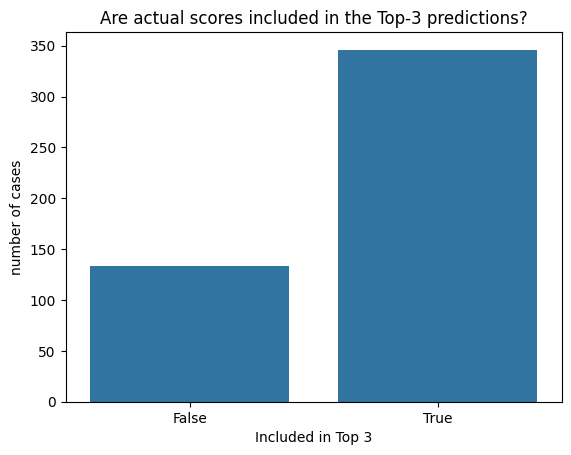


✅ Top-3 예측 결과 샘플:
  True Score  Top-1 Top-2 Top-3  Hit in Top-3
0        3-0    3-0   2-0   4-0          True
1        1-2    1-1   0-1   1-2          True
2        1-2    1-1   0-1   1-0         False
3        0-3    0-0   0-1   0-2         False
4        1-0    0-0   1-0   2-0          True
5        1-0    0-0   1-0   2-0          True
6        2-0    1-0   0-0   2-0          True
7        5-0  5+-5+   4-0   5-0          True
8        1-2    1-1   0-1   1-2          True
9        4-1  5+-5+   3-1   3-0         False

📊 Feature Importance (Home Goal Model)


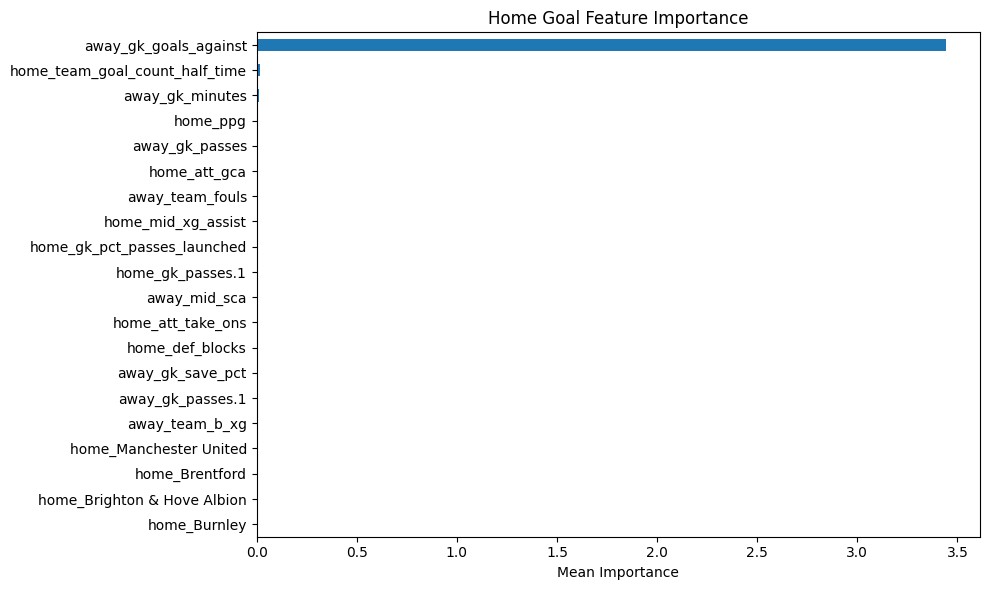


📊 Feature Importance (Away Goal Model)


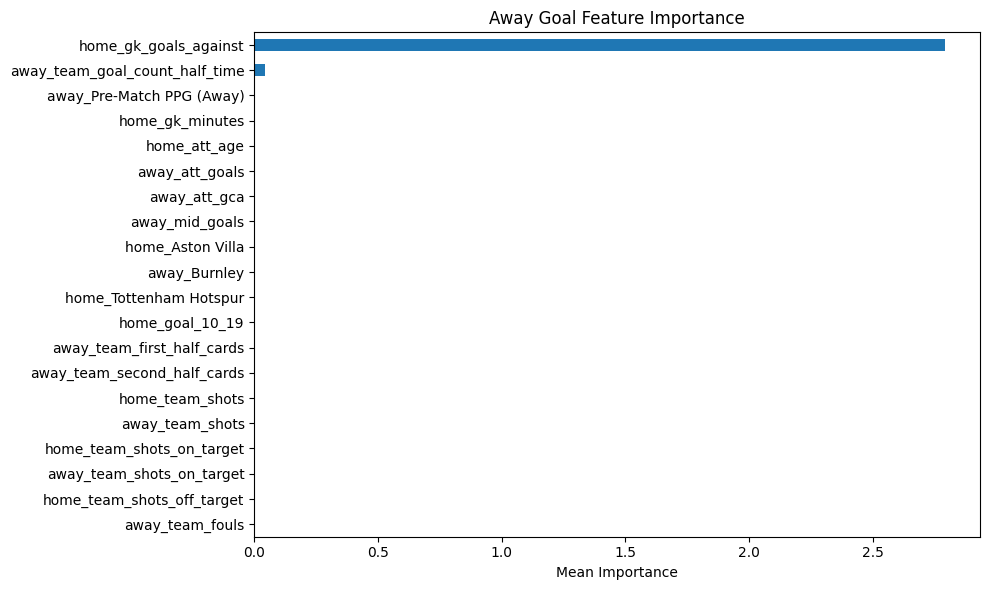

In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import poisson
from tqdm import tqdm
import seaborn as sns

# 1. 데이터 로딩 및 통합
input_dir = '../data/datas/2/final'
csv_files = sorted([f for f in os.listdir(input_dir) if f.startswith("final_") and f.endswith(".csv")])

season_dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(input_dir, file))
    df['season'] = file.replace('final_', '').replace('.csv', '')
    season_dfs.append(df)

df = pd.concat(season_dfs, ignore_index=True)
df['date'] = pd.to_datetime(df['date_GMT'], errors='coerce')
df = df.sort_values('date')

# 2. 피처 구성 및 인코딩
target_cols = ['home_team_goal_count', 'away_team_goal_count']
meta_cols_to_drop = ['date_GMT', 'date', 'season', 'home_result', 'away_result']
X_raw = df.drop(columns=target_cols + meta_cols_to_drop, errors='ignore')
X_raw = X_raw.select_dtypes(include=['number'])  # 숫자형만 사용

team_dummies = pd.get_dummies(df[['home_team_name', 'away_team_name']], prefix=['home', 'away'])
X = pd.concat([X_raw, team_dummies], axis=1).dropna()

y_home = df.loc[X.index, 'home_team_goal_count']
y_away = df.loc[X.index, 'away_team_goal_count']

# 3. 학습/검증/테스트 분할
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_home_train, y_home_val, y_home_test = y_home.iloc[:train_end], y_home.iloc[train_end:val_end], y_home.iloc[val_end:]
y_away_train, y_away_val, y_away_test = y_away.iloc[:train_end], y_away.iloc[train_end:val_end], y_away.iloc[val_end:]

# 4. 모델 학습
model_home = XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=4)
model_away = XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=4)
model_home.fit(X_train, y_home_train)
model_away.fit(X_train, y_away_train)

# 5. 평가 함수
def evaluate(model, X, y_true, name="home"):
    y_pred = model.predict(X).round().astype(int)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name.upper()}] - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    return y_pred, rmse, mae, r2

# 6. 분포 시각화
def plot_predictions(y_true, y_pred, label, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([0, 6], [0, 6], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title} - {label} (Scatter)")

    plt.subplot(1, 2, 2)
    plt.hist(y_true, bins=range(0, 8), alpha=0.5, label="Actual", density=True)
    plt.hist(y_pred, bins=range(0, 8), alpha=0.5, label="Predicted", density=True)
    plt.xlabel("Goals")
    plt.ylabel("Density")
    plt.title(f"{title} - {label} (Distribution)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 7. Poisson 기반 Top-3 점수 예측
def predict_scores_with_prob(x, max_goal=5, top_k=3):
    mu_home = model_home.predict(x)[0]
    mu_away = model_away.predict(x)[0]
    result = []
    rest_prob = 0

    for h in range(max_goal + 1):
        for a in range(max_goal + 1):
            p = poisson.pmf(h, mu_home) * poisson.pmf(a, mu_away)
            result.append(((h, a), p))

    for h in range(max_goal + 1):
        rest_prob += poisson.pmf(h, mu_home) * (1 - poisson.cdf(max_goal, mu_away))
        rest_prob += (1 - poisson.cdf(max_goal, mu_home)) * poisson.pmf(h, mu_away)
    rest_prob -= (1 - poisson.cdf(max_goal, mu_home)) * (1 - poisson.cdf(max_goal, mu_away))

    result.append((("5+", "5+"), rest_prob))
    return {
        "home_expected_goals": mu_home,
        "away_expected_goals": mu_away,
        "top_predictions": sorted(result, key=lambda x: x[1], reverse=True)[:top_k]
    }

# 8. 평가 결과 출력
print("✅ 검증 성능:")
y_home_val_pred, _, _, _ = evaluate(model_home, X_val, y_home_val, "home_val")
y_away_val_pred, _, _, _ = evaluate(model_away, X_val, y_away_val, "away_val")

print("\n✅ 테스트 성능:")
y_home_test_pred, _, _, _ = evaluate(model_home, X_test, y_home_test, "home_test")
y_away_test_pred, _, _, _ = evaluate(model_away, X_test, y_away_test, "away_test")

# 9. Poisson Top-3 결과 확인
results = []
for i in tqdm(range(len(X_test))):
    x = X_test.iloc[[i]]
    true_home = y_home_test.iloc[i]
    true_away = y_away_test.iloc[i]
    pred = predict_scores_with_prob(x, top_k=3)
    top_scores = [f"{h}-{a}" for (h, a), _ in pred["top_predictions"]]
    true_score = f"{true_home}-{true_away}"
    hit = true_score in top_scores

    results.append({
        "True Score": true_score,
        "Top-1": top_scores[0],
        "Top-2": top_scores[1] if len(top_scores) > 1 else "-",
        "Top-3": top_scores[2] if len(top_scores) > 2 else "-",
        "Hit in Top-3": hit
    })

df_results = pd.DataFrame(results)
print("\n📊 테스트 전체에서 실제 스코어가 Top-3 안에 포함된 비율:")
print(f"→ {df_results['Hit in Top-3'].mean():.2%}")

# 10. 시각화
sns.countplot(data=df_results, x="Hit in Top-3")
plt.title("Are actual scores included in the Top-3 predictions?")
plt.xlabel("Included in Top 3")
plt.ylabel("number of cases")
plt.show()

print("\n✅ Top-3 예측 결과 샘플:")
print(df_results.head(10))

# 11. Feature 중요도 시각화
def plot_feature_importance(model, X_val, y_val, title="Permutation Importance", top_n=20):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
    importance_series = pd.Series(result.importances_mean, index=X_val.columns)
    top_features = importance_series.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh')
    plt.title(title)
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()


print("\n📊 Feature Importance (Home Goal Model)")
plot_feature_importance(model_home, X_val, y_home_val, title="Home Goal Feature Importance", top_n=20)

print("\n📊 Feature Importance (Away Goal Model)")
plot_feature_importance(model_away, X_val, y_away_val, title="Away Goal Feature Importance", top_n=20)
